<a href="https://colab.research.google.com/github/synzen/nyc-transpo/blob/master/nyc_transpo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import pandas as pd
from datetime import datetime, time
import numpy as np
import requests, zipfile, io, os, re, csv, warnings, collections
import shapefile

%matplotlib notebook
import matplotlib.pyplot as plt
import preprocessing.constants as constants
import features.common.zones as zones
from IPython.display import clear_output
from preprocessing.taxi import get_parsed_df as get_parsed_taxi_df
from preprocessing.bike import get_parsed_df as get_parsed_bike_df
from preprocessing.common import clean_column_names

from sklearn.model_selection import train_test_split
from sklearn import linear_model
import statsmodels.api as sm


# Ignore the warnings about storing incompatible data types HDFStore
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)

# Dataframe Loading/Cleaning/Features

In [8]:
def remove_outliers(df):
  # tripduration is in seconds
  return df[(df['tripduration'] < 60 * 60 * 5) & (df['trip_distance'] > 0) & (df['tripduration'] > 60) & (df['trip_distance'] <= 20)]

## Taxi Data
Since these downloads take a long time, do NOT reset all run times if you are not on localhost when it asks you to! It will wipe all downloaded files, and you'll have to download them again!

Note that the features are added in here as well for efficiency.

In [9]:
taxi_store = pd.HDFStore(constants.TAXI_DATA_PATH + '/dataframes.h5')

In [10]:
df_taxi_2013 = remove_outliers(get_parsed_taxi_df("2013", taxi_store))
df_taxi_2014 = remove_outliers(get_parsed_taxi_df("2014", taxi_store))
df_taxi_2015 = remove_outliers(get_parsed_taxi_df("2015", taxi_store))
df_taxi_2016 = remove_outliers(get_parsed_taxi_df("2016", taxi_store))
df_taxi_2017 = remove_outliers(get_parsed_taxi_df("2017", taxi_store))
df_taxi_2018 = remove_outliers(get_parsed_taxi_df("2018", taxi_store))

#attempt at adding zone_from_to to 2017 and 2018 taxi dataframes.

def from_to_zid(from_id, to_id):
   try:
     return zones.ZONES_DIC[str(float(from_id))].name + ' to ' + zones.ZONES_DIC[str(float(to_id))].name
   except Exception as ex:
     return np.nan

def add_zones(df):
   df['zone_from'] = df['PULocationID']
   df['zone_to'] = df['DOLocationID']
   df['zone_from_to'] = np.vectorize(from_to_zid)(df.zone_from, df.zone_to)

for df in [df_taxi_2017, df_taxi_2018]:
   add_zones(df)
   df.dropna(subset=['zone_from', 'zone_to', 'zone_from_to'], inplace=True)
   df.drop(df[df['zone_from_to'] == 'nan'].index, inplace=True)

df_taxi_all = [df_taxi_2013, df_taxi_2014, df_taxi_2015, df_taxi_2016, df_taxi_2017, df_taxi_2018]

clear_output()

In [11]:
# Just like an open file, it must be closed to release the file lock.
taxi_store.close()

## Citi Bike Data
Note that the features are added in here as well for efficiency.

In [12]:
bike_store = pd.HDFStore(constants.BIKE_DATA_PATH + '/dataframes.h5')

In [13]:
df_bike_2013 = remove_outliers(get_parsed_bike_df('2013', bike_store))
df_bike_2014 = remove_outliers(get_parsed_bike_df('2014', bike_store))
df_bike_2015 = remove_outliers(get_parsed_bike_df('2015', bike_store))
df_bike_2016 = remove_outliers(get_parsed_bike_df('2016', bike_store))
df_bike_2017 = remove_outliers(get_parsed_bike_df('2017', bike_store))
df_bike_2018 = remove_outliers(get_parsed_bike_df('2018', bike_store))
df_bike_all = [df_bike_2013, df_bike_2014, df_bike_2015, df_bike_2016, df_bike_2017, df_bike_2018]

clear_output()

In [14]:
bike_store.close()

## Features Not Yet Migrated
This still needs to be moved to the external py files of `features/bike.py` and `features/taxi.py` file - optimizations can be done first before moving it, perhaps?

### Zones / Neighborhoods
Define NYC taxi zone as a feature for all df

In [ ]:
#attempt at adding zone_from_to to 2017 and 2018 taxi dataframes.  Results in a high # of nan vals?

##def from_to_zid(from_id, to_id):
#    try:
#      return zones.ZONES_DIC[str(float(from_id))].name + ' to ' + zones.ZONES_DIC[str(float(to_id))].name
##    except Exception as ex:
 #     return np.nan

#def add_zones(df):
##    df['zone_from'] = df['PULocationID']
#    df['zone_to'] = df['DOLocationID']
#    df['zone_from_to'] = np.vectorize(from_to_zid)(df.zone_from, df.zone_to)

#for df in [df_taxi_2017, df_taxi_2018]:
#    add_zones(df)
#    df.dropna(subset=['zone_from', 'zone_to', 'zone_from_to'], inplace=True)
#    df.drop(df[df['zone_from_to'] == 'nan'].index, inplace=True)


# Exploratory Data Analysis

### Trip Distance

bike mean:  1.209619836382246
taxi mean:  2.922218640645345


<IPython.core.display.Javascript object>


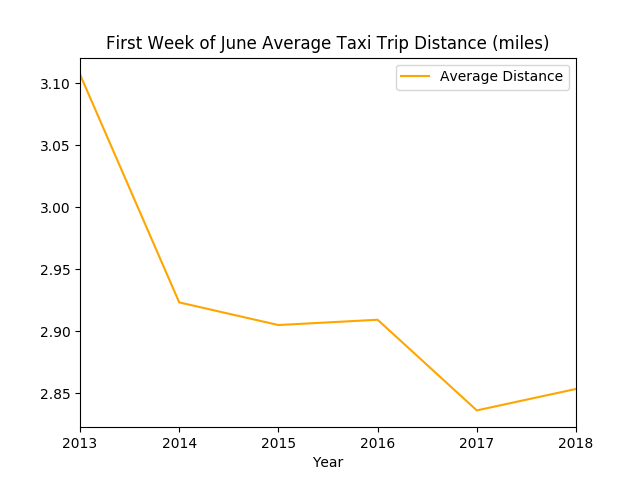

<IPython.core.display.Javascript object>


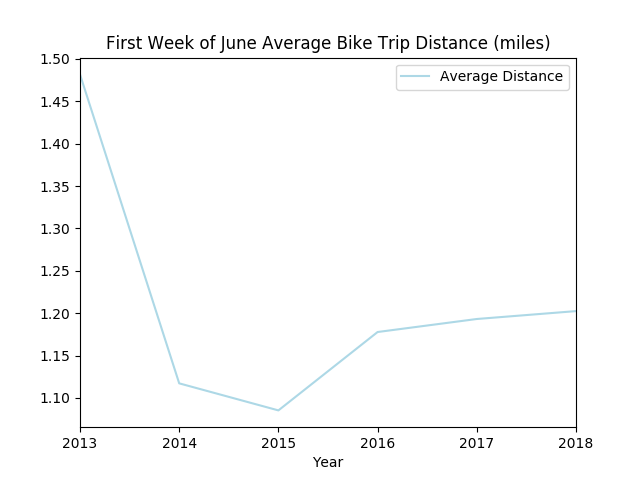

<IPython.core.display.Javascript object>


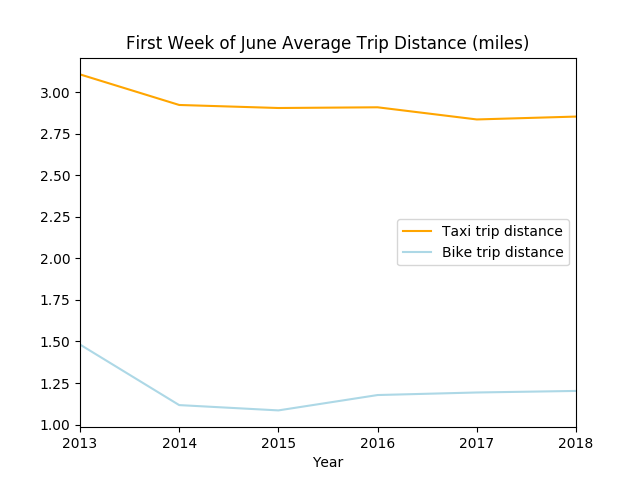

In [15]:
avg_trip_distance_bike = pd.DataFrame(
    {'Year': constants.YEARS,
     'Average Distance': [
         df_bike_2013.trip_distance.mean(),
         df_bike_2014.trip_distance.mean(),
         df_bike_2015.trip_distance.mean(),
         df_bike_2016.trip_distance.mean(),
         df_bike_2017.trip_distance.mean(),
         df_bike_2018.trip_distance.mean()
     ]})

print('bike mean: ',np.mean([df_bike_2013.trip_distance.mean(),
         df_bike_2014.trip_distance.mean(),
         df_bike_2015.trip_distance.mean(),
         df_bike_2016.trip_distance.mean(),
         df_bike_2017.trip_distance.mean(),
         df_bike_2018.trip_distance.mean()]))

avg_trip_distance_taxi = pd.DataFrame(
    {'Year': constants.YEARS,
     'Average Distance': [
         df_taxi_2013.trip_distance.mean(),
         df_taxi_2014.trip_distance.mean(),
         df_taxi_2015[df_taxi_2015.trip_distance < 500].trip_distance.mean(), # remove weirdly high trip distances...
         df_taxi_2016.trip_distance.mean(),
         df_taxi_2017.trip_distance.mean(),
         df_taxi_2018.trip_distance.mean()
     ]})

print('taxi mean: ',np.mean([df_taxi_2013.trip_distance.mean(),
         df_taxi_2014.trip_distance.mean(),
         df_taxi_2015[df_taxi_2015.trip_distance < 500].trip_distance.mean(), # remove weirdly high trip distances...
         df_taxi_2016.trip_distance.mean(),
         df_taxi_2017.trip_distance.mean(),
         df_taxi_2018.trip_distance.mean()]))

avg_trip_distance_taxi.plot(
    kind='line', x='Year', y='Average Distance', title='First Week of June Average Taxi Trip Distance (miles)', color='orange')
avg_trip_distance_bike.plot(
    kind='line', x='Year', y='Average Distance', title='First Week of June Average Bike Trip Distance (miles)', color='lightblue')

_ = avg_trip_distance_taxi.plot(
    kind='line', x='Year', y='Average Distance', title='First Week of June Average Trip Distance (miles)', color='orange')
avg_trip_distance_bike.plot(
    kind='line', x='Year', y='Average Distance', title='First Week of June Average Trip Distance (miles)', ax=_, color='lightblue')
_.legend(['Taxi trip distance', 'Bike trip distance'])

### Trip Duration

bike trip duration mean:  925.8825770776102
taxi trip duration mean: 838.7055422175093


<IPython.core.display.Javascript object>


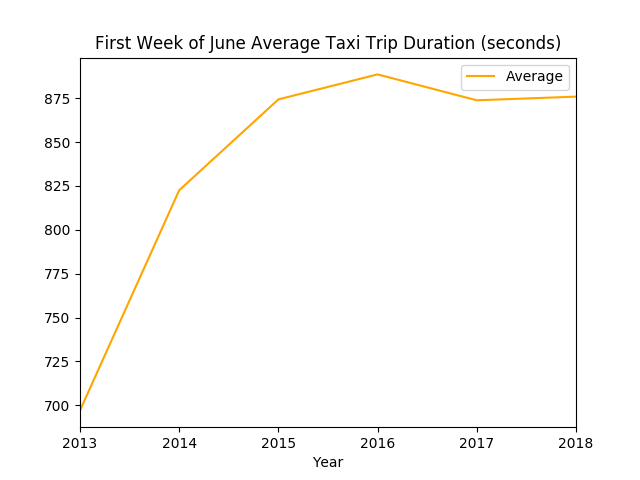

<IPython.core.display.Javascript object>


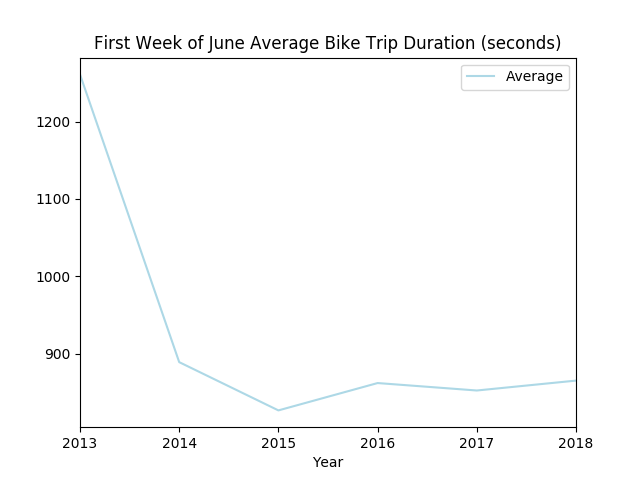

<IPython.core.display.Javascript object>


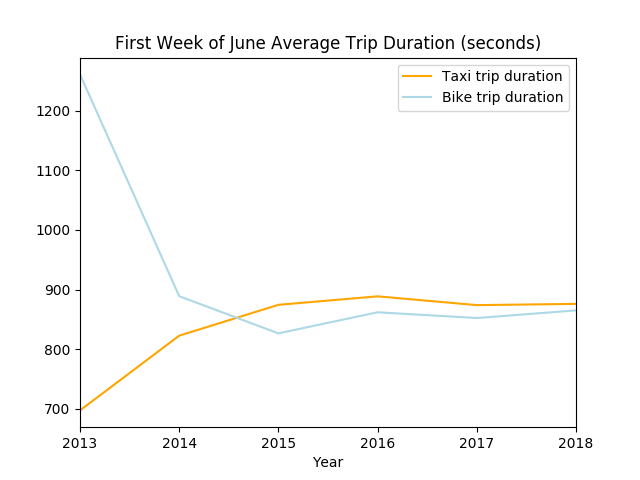

In [16]:
# Create average trip duration dataframes and plot

avg_trip_duration_bike = pd.DataFrame(
    {'Year': constants.YEARS, 
     'Average': [
        df_bike_2013.tripduration.mean(),
        df_bike_2014.tripduration.mean(),
        df_bike_2015.tripduration.mean(),
        df_bike_2016.tripduration.mean(),
        df_bike_2017.tripduration.mean(),
        df_bike_2018.tripduration.mean()] 
    })
print('bike trip duration mean: ',np.mean([
        df_bike_2013.tripduration.mean(),
        df_bike_2014.tripduration.mean(),
        df_bike_2015.tripduration.mean(),
        df_bike_2016.tripduration.mean(),
        df_bike_2017.tripduration.mean(),
        df_bike_2018.tripduration.mean()] ))

avg_trip_duration_taxi = pd.DataFrame(
    {'Year': constants.YEARS,
     'Average': [
         df_taxi_2013.tripduration.mean(),
         df_taxi_2014.tripduration.mean(),
         df_taxi_2015.tripduration.mean(),
         df_taxi_2016.tripduration.mean(),
         df_taxi_2017.tripduration.mean(),
         df_taxi_2018.tripduration.mean()]
    })

print('taxi trip duration mean:', np.mean([
         df_taxi_2013.tripduration.mean(),
         df_taxi_2014.tripduration.mean(),
         df_taxi_2015.tripduration.mean(),
         df_taxi_2016.tripduration.mean(),
         df_taxi_2017.tripduration.mean(),
         df_taxi_2018.tripduration.mean()]))

avg_trip_duration_taxi.plot(
    kind='line', x='Year', y='Average', title='First Week of June Average Taxi Trip Duration (seconds)', color='orange')

avg_trip_duration_bike.plot(
    kind='line', x='Year', y='Average', title='First Week of June Average Bike Trip Duration (seconds)', color='lightblue')

_ = avg_trip_duration_taxi.plot(
    kind='line', x='Year', y='Average', title='First Week of June Average Trip Duration (seconds)', color='orange')
avg_trip_duration_bike.plot(
    kind='line', x='Year', y='Average', title='First Week of June Average Trip Duration (seconds)', ax=_, color='lightblue')
_.legend(['Taxi trip duration', 'Bike trip duration'])


#fig.savefig('trip_duration.jpg')

In [ ]:
df_bike_2013.reset_index().plot(kind='scatter', x='index', y='tripduration')
df_taxi_2013.reset_index().plot(kind='scatter', x='index', y='tripduration')

### CitiBike rider age

In [17]:
# had to avoid 2014 here, as there are some issues with the birthdate field in that dataframe. Will clean.
# yo people in their 40s love citibikes

citi_avg_age = []

citi_avg_age.append(df_bike_2013["birth_year"].mean())
citi_avg_age.append("NaN")
citi_avg_age.append(df_bike_2015["birth_year"].mean())
citi_avg_age.append(df_bike_2016["birth_year"].mean())
citi_avg_age.append(df_bike_2017["birth_year"].mean())
citi_avg_age.append(df_bike_2018["birth_year"].mean())

print(citi_avg_age)

[1973.768541887161, 'NaN', 1976.320198510524, 1977.48909828384, 1978.7112779676524, 1978.749907413158]


### Number of Trips

<IPython.core.display.Javascript object>


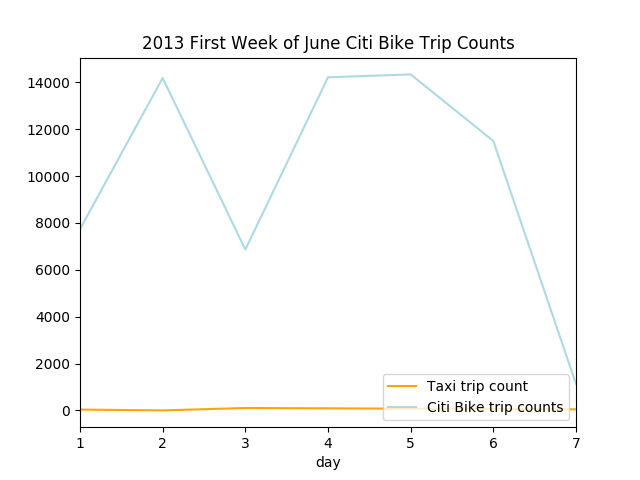

<IPython.core.display.Javascript object>


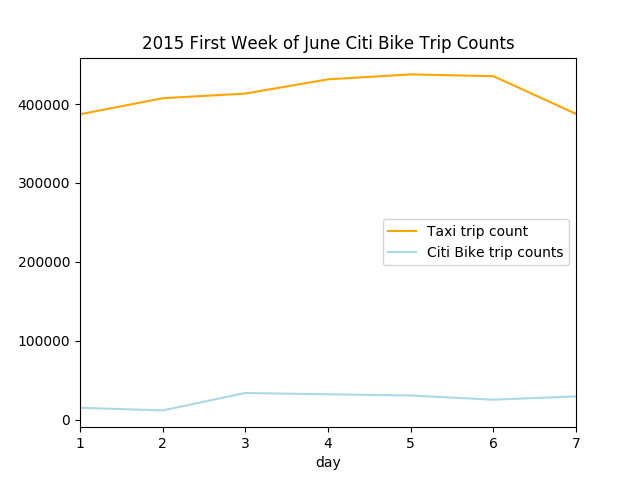

<IPython.core.display.Javascript object>


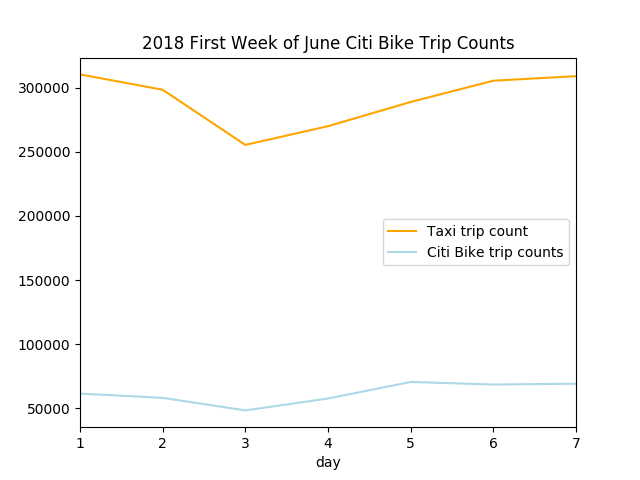

In [18]:
first_plot = df_taxi_2013.groupby(by='day').size().reset_index(name='counts').plot(kind='line', x='day', y='counts', title='2013 First Week of June Taxi Trip Counts', color='orange')
df_bike_2013.groupby(by='day').size().reset_index(name='counts').plot(kind='line', x='day', y='counts', title='2013 First Week of June Citi Bike Trip Counts', ax=first_plot, color='lightblue')
first_plot.legend(['Taxi trip count', 'Citi Bike trip counts'])

first_plot = df_taxi_2015.groupby(by='day').size().reset_index(name='counts').plot(kind='line', x='day', y='counts', title='2015 First Week of June Taxi Trip Counts', color='orange')
df_bike_2015.groupby(by='day').size().reset_index(name='counts').plot(kind='line', x='day', y='counts', title='2015 First Week of June Citi Bike Trip Counts', ax=first_plot, color='lightblue')
first_plot.legend(['Taxi trip count', 'Citi Bike trip counts'])

first_plot = df_taxi_2018.groupby(by='day').size().reset_index(name='counts').plot(kind='line', x='day', y='counts', title='2018 First Week of June Taxi Trip Counts', color='orange')
df_bike_2018.groupby(by='day').size().reset_index(name='counts').plot(kind='line', x='day', y='counts', title='2018 First Week of June Citi Bike Trip Counts', ax=first_plot, color='lightblue')
first_plot.legend(['Taxi trip count', 'Citi Bike trip counts'])

In [ ]:
# Make new data frames for yearly trip counts, and graph them

df_taxi_trip_counts = pd.DataFrame({'Year': constants.YEARS, 'Count': [
    df_taxi_2013.groupby(by='day').size().sum(),
    df_taxi_2014.groupby(by='day').size().sum(),
    df_taxi_2015.groupby(by='day').size().sum(),
    df_taxi_2016.groupby(by='day').size().sum(),
    df_taxi_2017.groupby(by='day').size().sum(),
    df_taxi_2018.groupby(by='day').size().sum(),
]})

df_bike_trip_counts = pd.DataFrame({'Year': constants.YEARS, 'Count': [
    df_bike_2013.groupby(by='day').size().sum(),
    df_bike_2014.groupby(by='day').size().sum(),
    df_bike_2015.groupby(by='day').size().sum(),
    df_bike_2016.groupby(by='day').size().sum(),
    df_bike_2017.groupby(by='day').size().sum(),
    df_bike_2018.groupby(by='day').size().sum(),
]})

In [19]:
df_taxi_trip_counts.plot(kind='line', x='Year', y='Count', title='First Week of June Yearly Taxi Trip Counts', color='orange')
df_bike_trip_counts.plot(kind='line', x='Year', y='Count', title='First Week of June Yearly Trip Counts', color='lightblue') 

first_plot = df_taxi_trip_counts.plot(kind='line', x='Year', y='Count', title='First Week of June Yearly Taxi Trip Counts', color='orange')
df_bike_trip_counts.plot(kind='line', x='Year', y='Count', title='First Week of June Yearly Trip Counts', ax=first_plot, color='lightblue')
first_plot.legend(['Taxi trip count', 'Citi Bike trip count'])

NameError: name 'df_taxi_trip_counts' is not defined

### Ridership Difference Between 2017-2018

In [33]:
def get_ridership_counts(dfs):
  """Returns a list of dicts with zone names as keys, each list index is the year in order"""
  ridership_counts = []
  for index, df in enumerate(dfs):
    ridership_counts.append({})
    for route, count in df.loc[df['zone_from'] != df['zone_to']].groupby('zone_from').size().items():
      ridership_counts[index][zones.ZONES_DIC[str(float(route))].name] = count
  return ridership_counts

taxi_ridership_counts = get_ridership_counts(df_taxi_all)
bike_ridership_counts = get_ridership_counts(df_bike_all)

def get_ridership_differences(ridership_counts):
  """Returns a dict of lists with zone names as keys"""
  ridership_differences = {}
  for index in range(len(df_taxi_all)):
    # Skip the zero'th index since we need the the previous df to calculate differences
    if index == 0:
      continue

    for key, val in zones.ZONES_DIC.items():
      zone_name = val.name
      # Initialize the ridership differences list for this zone if it doesn't exist
      if zone_name not in ridership_differences:
        ridership_differences[zone_name] = [] # Each index indicates current year minus past year

      # We can only calculate differences where the route exists for both the previous and current year
      if zone_name in ridership_counts[index-1] and zone_name in ridership_counts[index]:

        previous_year_ridership = ridership_counts[index - 1][zone_name]
        current_year_ridership = ridership_counts[index][zone_name]
        ridership_differences[zone_name].append(current_year_ridership - previous_year_ridership)
      else:
        ridership_differences[zone_name].append(-9999)
  return ridership_differences
        
  
taxi_ridership_differences = get_ridership_differences(taxi_ridership_counts)
bike_ridership_differences = get_ridership_differences(bike_ridership_counts)

In [42]:
'''Write new zone shape files with ridership attributes'''

r = shapefile.Reader("./taxi_zones/geo_export_a619f821-072d-486f-8172-0c1be3f7e97d")

w = shapefile.Writer("./taxi_zones/taxi_zones2")

# Copy over the existing fields
w.fields = list(r.fields)

# Add our new field using the pyshp API
taxi_ridership_fields = ['rdt14','rdt15','rdt16','rdt17',
                    'rdt18']
                    
bike_ridership_fields = ['rdb14','rdb15','rdb16','rdb17',
                   'rdb18']


for field in taxi_ridership_fields:
    w.field(field, "N", "10")

for field in bike_ridership_fields:
    w.field(field, "N", "10")
    
for shaperec in r.iterShapeRecords():
    rec = shaperec.record
    zname = rec.zone
    
    taxi_ridership = taxi_ridership_differences[zname]
    bike_ridership = bike_ridership_differences[zname]
    
    for i in range(0,5):
        rec.append(taxi_ridership[i])
    
    for i in range(0,5):
        rec.append(bike_ridership[i])
        
    w.record(*rec)
    w.shape(shaperec.shape)

# # Save as a new shapefile (or write over the old one)
w.close() 

In [43]:
'import new shapefiles'
import geopandas as gpd
zones2 = gpd.read_file("./taxi_zones/taxi_zones2.shp")


<IPython.core.display.Javascript object>


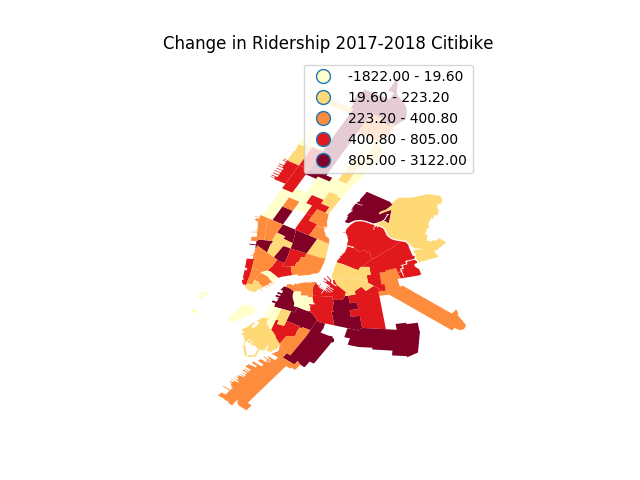

Text(0.5, 1.0, 'Change in Ridership 2017-2018 Citibike')

In [44]:
'''citibike ridership'''
fig, ax = plt.subplots(1, 1)

rdb18 = zones2[zones2['rdb18'] != -9999]
rdb18.plot(column='rdb18',ax=ax,legend=True,cmap='YlOrRd',scheme='quantiles')
plt.axis('off')
plt.title('Change in Ridership 2017-2018 Citibike')

<IPython.core.display.Javascript object>


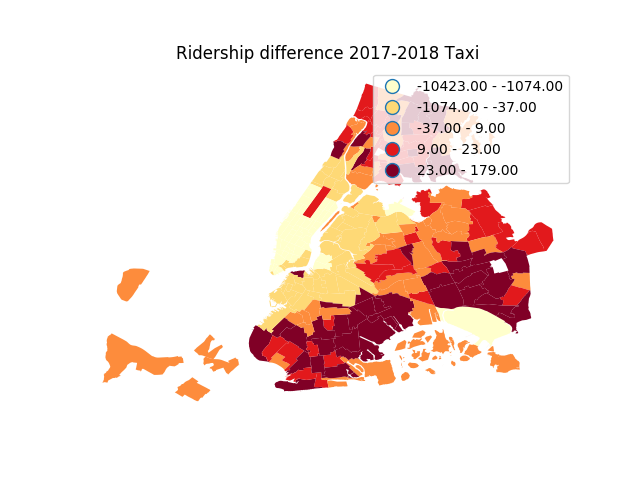

Text(0.5, 1.0, 'Ridership difference 2017-2018 Taxi')

In [40]:
'''Taxi ridership'''
fig, ax = plt.subplots(1, 1)

rdt18 = zones2[zones2['rdt18'] != -9999]
rdt18.plot(column='rdt18',ax=ax,legend=True,cmap='YlOrRd',scheme='quantiles')
plt.axis('off')
plt.title('Ridership difference 2017-2018 Taxi')

#### Popular Routes

In [42]:
print('10 most frequent inter-zone trips by Taxi (2016)')
df_taxi_2016[df_taxi_2016.zone_from != df_taxi_2016.zone_to].zone_from_to.value_counts()[0:10]

10 most frequent inter-zone trips by Taxi (2016)


Central Park to Midtown Center         40182
Midtown Center to Central Park         38253
Clinton East to Central Park           30965
Central Park to Clinton East           26946
East Chelsea to Clinton East           24642
Lincoln Square East to Central Park    20565
Clinton East to East Chelsea           20460
Central Park to Midtown East           20444
Midtown East to Central Park           20418
Clinton East to Midtown Center         19449
Name: zone_from_to, dtype: int64

In [43]:
print('10 most frequent inter-zone trips by Bike (2016)')
df_bike_2016[df_bike_2016.zone_from != df_bike_2016.zone_to].zone_from_to.value_counts()[0:10]

10 most frequent inter-zone trips by Bike (2016)


Clinton East to East Chelsea               3048
East Chelsea to Clinton East               2753
Central Park to Clinton East               2102
Greenwich Village North to East Village    1945
East Village to Greenwich Village North    1928
Clinton East to Central Park               1830
Clinton East to Midtown Center             1817
Greenwich Village North to East Chelsea    1814
Central Park to Midtown Center             1809
East Village to Alphabet City              1762
Name: zone_from_to, dtype: int64

In [44]:
print('10 most frequent trips by Bike (2016)')
df_bike_2016.zone_from_to.value_counts()[0:10]

10 most frequent trips by Bike (2016)


Central Park to Central Park                          11676
East Chelsea to East Chelsea                           6595
Clinton East to Clinton East                           3629
Clinton East to East Chelsea                           3048
East Chelsea to Clinton East                           2753
East Village to East Village                           2239
Central Park to Clinton East                           2102
Greenwich Village North to East Village                1945
East Village to Greenwich Village North                1928
Greenwich Village North to Greenwich Village North     1860
Name: zone_from_to, dtype: int64

In [45]:
print('10 most frequent trips by Taxi (2016)')
df_taxi_2016.zone_from_to.value_counts()[0:10]

10 most frequent trips by Taxi (2016)


Central Park to Central Park           231133
Central Park to Midtown Center          40182
Midtown Center to Central Park          38253
Clinton East to Central Park            30965
East Chelsea to East Chelsea            30808
Central Park to Clinton East            26946
East Chelsea to Clinton East            24642
Clinton East to Clinton East            23003
Lincoln Square East to Central Park     20565
Clinton East to East Chelsea            20460
Name: zone_from_to, dtype: int64

In [46]:
print('10 most frequent trips by Taxi (2018)')
df_taxi_2018.zone_from_to.value_counts()[0:10]

10 most frequent trips by Taxi (2018)


Upper East Side South to Upper East Side North    13745
Upper East Side North to Upper East Side South    11686
Upper East Side North to Upper East Side North    10769
Upper East Side South to Upper East Side South    10118
Upper West Side South to Upper West Side North     6038
Upper West Side South to Lincoln Square East       5911
Upper East Side South to Midtown East              5677
Upper East Side South to Midtown Center            5528
Upper West Side North to Upper West Side South     5353
Lincoln Square East to Upper West Side South       5185
Name: zone_from_to, dtype: int64

In [47]:
print('Most common trips to Manhattanville (City College) Zone by Taxi 2016\n')

zone_from = df_taxi_2016[df_taxi_2016.zone_to == 152.0].zone_from.value_counts().index[0:10]
for zone_id in zone_from:
    z = constants.ZONES_DIC[str(zone_id)]
    print(z.name,'to Manhattanville')

Most common trips to Manhattanville (City College) Zone by Taxi 2016

Central Park to Manhattanville
Bloomingdale to Manhattanville
Clinton East to Manhattanville
Central Harlem North to Manhattanville
Central Harlem to Manhattanville
East Chelsea to Manhattanville
Manhattanville to Manhattanville
Lincoln Square East to Manhattanville
East Harlem North to Manhattanville
Midtown Center to Manhattanville


# More Analysis

## Most Popular Routes
We wil examine the top routes that were used by both taxis and bikes in 2018, the most recent year.

First we take count of all the routes

In [48]:
bike_routes_counts = {}
taxi_routes_counts = {}
intersection_routes_counts = {}

# First exclude the routes where the start and end destinations are the same since they may not be representative of actual commutes
bike_all_routes = df_bike_2018[df_bike_2018['zone_from'] != df_bike_2018['zone_to']].groupby('zone_from_to').size()
taxi_all_routes = df_taxi_2018[df_taxi_2018['zone_from'] != df_taxi_2018['zone_to']].groupby('zone_from_to').size()

for index, val in bike_all_routes.items():
  bike_routes_counts[index] = val
  
for index, val in taxi_all_routes.items():
  taxi_routes_counts[index] = val
  if index in bike_routes_counts:
    intersection_routes_counts[index] = bike_routes_counts[index] + val

Find the top 100 intersecting routes

In [49]:
bike_routes_names = list(bike_all_routes.keys())
taxi_routes_names = list(taxi_all_routes.keys())
intersection_routes_names = list(collections.OrderedDict(sorted(intersection_routes_counts.items(), key=lambda kv: kv[1], reverse=True)).keys()) # Super complicated I know
intersection_top_routes_names = intersection_routes_names[0:100]

df_bike_top_routes_intersected = df_bike_2018.loc[df_bike_2018['zone_from_to'].isin(intersection_top_routes_names)]
df_taxi_top_routes_intersected = df_taxi_2018.loc[df_taxi_2018['zone_from_to'].isin(intersection_top_routes_names)]

Before we deal with the 100 top intersecting routes, we'll see how many of all trips within all intersecting routes were actually bikes

In [50]:
bike_route_majorities = 0
taxi_route_majorities = 0
total_routes = len(intersection_routes_names)
no_majority = 0
total_trips = 0

for route in intersection_routes_names:
  bike_count = bike_routes_counts[route]
  taxi_count = taxi_routes_counts[route]
  total_trips += bike_count + taxi_count
  if bike_count > taxi_count:
    bike_route_majorities += 1
  elif taxi_count > bike_count:
    taxi_route_majorities += 1
  else:
    no_majority += 1

print(f"With {total_routes} possible routes and {total_trips} total trips, {bike_route_majorities / total_routes*100:.2f}% were bikes")

With 4295 possible routes and 1430402 total trips, 24.33% were bikes


And finally get our juicy data from those 100 routes. Here we are making the assumption that a particular route from one zone to another is exact same for all bikes and taxis to make our analysis easier (but of course in reality, they are not).

In [53]:
bike_wins = 0
taxi_wins = 0
no_wins = 0

bike_trips = 0
taxi_trips = 0

bike_use_route_percentages = {}
bike_faster_route_percentages = {}

print('Calculating with ' + str(len(intersection_top_routes_names)) + " top intersecting routes")
for route in intersection_top_routes_names:
  bike_mean = df_bike_top_routes_intersected.loc[df_bike_top_routes_intersected['zone_from_to'] == route]['tripduration'].mean()
  taxi_mean = df_taxi_top_routes_intersected.loc[df_taxi_top_routes_intersected['zone_from_to'] == route]['tripduration'].mean()
  
  this_bike_trips = bike_routes_counts[route]
  this_taxi_trips = taxi_routes_counts[route]
  this_all_trips = this_bike_trips + this_taxi_trips
  
  bike_trips += this_bike_trips
  taxi_trips += this_taxi_trips
                    
  bike_use_route_percentages[route] = this_bike_trips / this_all_trips;
  if bike_mean > taxi_mean:
    bike_faster_route_percentages[route] = bike_mean / (bike_mean + taxi_mean)
  
  more_taxi = this_taxi_trips > this_bike_trips
  equal_trips = this_bike_trips == this_taxi_trips
  print_str = ""
  if more_taxi:
    print_str = f"taxis are used more often {this_taxi_trips / this_all_trips * 100:.2f}% of trips were taxis"
  elif equal_trips:
    print_str = "taxis are used equally as bikes"
  else:
    print_str = f"bikes are used more often {this_bike_trips / this_all_trips * 100:.2f}% of trips were bikes"
    
    
  if bike_mean < taxi_mean:
    bike_wins += 1
    #print(route + " - Bike is faster on average, " + print_str)
  elif bike_mean > taxi_mean:
    taxi_wins += 1
    #print(route + " - Taxi is faster on average, " + print_str)
  else:
    no_wins += 1
    #print(route + " - Bike and taxi are equal on average" + print_str)
    
print("\n")


all_trips = bike_trips + taxi_trips
print(f"There were {bike_trips/all_trips*100:.2f}% bike trips and {taxi_trips/all_trips*100:.2f}% taxi trips (total: {all_trips}).")
  
taxi_wins_percent = taxi_wins / (bike_wins + taxi_wins + no_wins) * 100
print(f"Taxi is, on average, faster {taxi_wins_percent:.2f}% of the time for the top routes")

Calculating with 100 top intersecting routes


There were 24.88% bike trips and 75.12% taxi trips (total: 317517).
Taxi is, on average, faster 74.00% of the time for the top routes


**What routes were bikes used the most?**

In [54]:
# Get the top bike percentages
top_bike_routes = list(collections.OrderedDict(sorted(bike_use_route_percentages.items(), key=lambda kv: kv[1], reverse=True)).items())
print("Most Used Bike Routes Compared To Taxis (2018)\n---------")
for i in range(10):
  print(top_bike_routes[i][0] + f" ({top_bike_routes[i][1]*100:.2f}%)")

Most Used Bike Routes Compared To Taxis (2018)
---------
Alphabet City to East Village (81.57%)
Central Park to Clinton East (79.06%)
Central Park to Central Harlem (78.89%)
Clinton East to Central Park (71.84%)
Greenwich Village North to East Chelsea (65.19%)
East Chelsea to Greenwich Village North (64.47%)
Central Park to Midtown East (62.65%)
East Village to Greenwich Village North (62.12%)
East Chelsea to Gramercy (60.29%)
East Village to Alphabet City (59.52%)


**What routes were bikes faster than taxis, on average?**

In [55]:
print("Relatively Fastest Bike Routes Compared to Taxis (2018)\n---------")
fastest_bike_routes = list(collections.OrderedDict(sorted(bike_faster_route_percentages.items(), key=lambda kv: kv[1], reverse=True)).items())

for i in range(10):
  print(fastest_bike_routes[i][0] + f" ({fastest_bike_routes[i][1]*100:.2f}% faster than taxi)")
  

Relatively Fastest Bike Routes Compared to Taxis (2018)
---------
Yorkville West to Lenox Hill West (73.23% faster than taxi)
Lenox Hill West to Yorkville West (72.98% faster than taxi)
Lenox Hill East to Yorkville West (70.05% faster than taxi)
Upper West Side South to Lincoln Square East (67.72% faster than taxi)
Central Park to Central Harlem (66.19% faster than taxi)
Clinton East to East Chelsea (65.20% faster than taxi)
Clinton East to Clinton West (63.96% faster than taxi)
Clinton East to Central Park (63.72% faster than taxi)
Central Park to Lincoln Square East (63.61% faster than taxi)
Lincoln Square East to Upper West Side South (63.31% faster than taxi)


**How have taxis fared compared to bikes over the top bike routes from 2014-2018? Let's see!**

In [56]:
top_route_names = []
taxi_changes = []
bike_changes = []
for i in range(10):
  route_name = top_bike_routes[i][0]
  trips_taxi_2014 = len(df_taxi_2014.loc[df_taxi_2014['zone_from_to'] == route_name].index)
  trips_taxi_2018 = len(df_taxi_2018.loc[df_taxi_2018['zone_from_to'] == route_name].index)
  trips_bike_2014 = len(df_bike_2014.loc[df_bike_2014['zone_from_to'] == route_name].index)
  trips_bike_2018 = len(df_bike_2018.loc[df_bike_2018['zone_from_to'] == route_name].index)
  
  bike_change_percent = np.nan if trips_bike_2014 == 0 else (trips_bike_2018 - trips_bike_2014) / trips_bike_2014 * 100
  taxi_change_percent = np.nan if trips_taxi_2014 == 0 else (trips_taxi_2018 - trips_taxi_2014) / trips_taxi_2014 * 100

  top_route_names.append(route_name)
  bike_changes.append(bike_change_percent)
  taxi_changes.append(taxi_change_percent)  

In [57]:
def color_negative_red(val):
    if type(val) is str or np.isnan(val):
      return 'color: black'
    else:
      color = 'red' if val < 0 else 'green'
      return 'color: %s' % color


df_ridership_changes = pd.DataFrame({
    'Route': top_route_names,
    'Taxi Use Change (%)': taxi_changes,
    'Bike Use Change (%)': bike_changes
}).round(2)

df_ridership_changes.style.applymap(color_negative_red)

,Route,Taxi Use Change (%),Bike Use Change (%)
0,Alphabet City to East Village,-81.74,40.8
1,Central Park to Clinton East,-97.62,1094.9
2,Central Park to Central Harlem,-93.77,nan
3,Clinton East to Central Park,-97.39,848.69
4,Greenwich Village North to East Chelsea,-89.43,-2.44
5,East Chelsea to Greenwich Village North,-88.19,5.5
6,Central Park to Midtown East,-96.22,1659.09
7,East Village to Greenwich Village North,-69.66,36.46
8,East Chelsea to Gramercy,-90.97,12.14
9,East Village to Alphabet City,-67.29,38.48


Pretty darn bad. What about their usage change for all routes?

## DIfference in RIdership Per Zone
Here, we will calculate the ridership differences per zone for every year interval (2013 to 2014, 2014 to 2015, etc.) to use in our visualizations.

In [58]:
def get_ridership_counts(dfs):
  """Returns a list of dicts with zone names as keys, each list index is the year in order"""
  ridership_counts = []
  for index, df in enumerate(dfs):
    ridership_counts.append({})
    for route, count in df.loc[df['zone_from'] != df['zone_to']].groupby('zone_from').size().items():
      ridership_counts[index][zones.ZONES_DIC[str(float(route))].name] = count
  return ridership_counts

taxi_ridership_counts = get_ridership_counts(df_taxi_all)
bike_ridership_counts = get_ridership_counts(df_bike_all)

def get_ridership_differences(ridership_counts):
  """Returns a dict of lists with zone names as keys"""
  ridership_differences = {}
  for index in range(len(df_taxi_all)):
    # Skip the zero'th index since we need the the previous df to calculate differences
    if index == 0:
      continue

    for key, val in zones.ZONES_DIC.items():
      zone_name = val.name
      # Initialize the ridership differences list for this zone if it doesn't exist
      if zone_name not in ridership_differences:
        ridership_differences[zone_name] = [] # Each index indicates current year minus past year

      # We can only calculate differences where the route exists for both the previous and current year
      if zone_name in ridership_counts[index-1] and zone_name in ridership_counts[index]:

        previous_year_ridership = ridership_counts[index - 1][zone_name]
        current_year_ridership = ridership_counts[index][zone_name]
        ridership_differences[zone_name].append(current_year_ridership - previous_year_ridership)
      else:
        ridership_differences[zone_name].append(np.nan)
  return ridership_differences
        
  
taxi_ridership_differences = get_ridership_differences(taxi_ridership_counts)
bike_ridership_differences = get_ridership_differences(bike_ridership_counts)


# Linear Regression

To make sure Linear Regression is the correct model, we have to make the assumption that the relationship between trip distance and trip duration is linear. We can visualize this with a scatter plot.

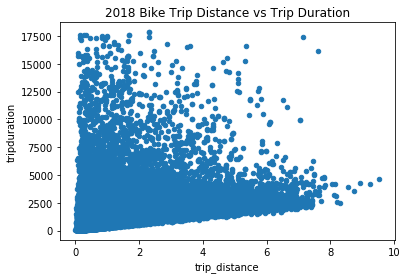

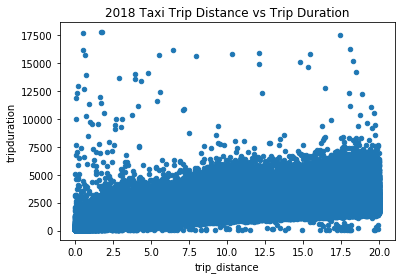

In [59]:
df_bike_2018.plot(kind='scatter', x='trip_distance', y='tripduration', title="2018 Bike Trip Distance vs Trip Duration")
df_taxi_2018.plot(kind='scatter', x='trip_distance', y='tripduration', title='2018 Taxi Trip Distance vs Trip Duration')

Close enough.

In [60]:
# concat the dataframes
dfs_2013 = pd.concat([df_taxi_2013, df_bike_2013], sort=True)
dfs_2014 = pd.concat([df_taxi_2014, df_bike_2014], sort=True)
dfs_2015 = pd.concat([df_taxi_2015, df_bike_2015], sort=True)
dfs_2016 = pd.concat([df_taxi_2016, df_bike_2016], sort=True)
dfs_2017 = pd.concat([df_taxi_2017, df_bike_2017], sort=True)
dfs_2018 = pd.concat([df_taxi_2018, df_bike_2018], sort=True)


The actual modeling happens here.

### targeting tripduration with trip_distance and is_bike

In [64]:
features=['trip_distance', 'is_bike']
target = 'tripduration'
df_model = dfs_2018
df_model = df_model
X = df_model[features]
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [65]:
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

#print('Intercept: \n', regr.intercept_)
#print('Coefficients: \n', regr.coef_)
print("R^2: " + str(regr.score(X_test, y_test)))

R^2: 0.5376702588037032


In [66]:
# with statsmodels
est = sm.OLS(y_train, sm.add_constant(X_train)).fit()

print_model = est.summary()
print(print_model)

/Users/Carl/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:           tripduration   R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                 1.134e+06
Date:                Wed, 15 May 2019   Prob (F-statistic):               0.00
Time:                        15:40:01   Log-Likelihood:            -1.5048e+07
No. Observations:             1977564   AIC:                         3.010e+07
Df Residuals:                 1977561   BIC:                         3.010e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           396.9611      0.498    797.740

### targeting tripduration with zone_to, zone_from, day, is_bike, time

In [67]:
features=['day', 'start_time', 'zone_to', 'zone_from', 'is_bike']
target = 'tripduration'
df_model = dfs_2018
df_model = df_model
X = df_model[features]
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [68]:
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

#print('Intercept: \n', regr.intercept_)
#print('Coefficients: \n', regr.coef_)
print("R^2: " + str(regr.score(X_test, y_test)))

R^2: 0.010751352543384773


In [69]:
# with statsmodels
est = sm.OLS(y_train, sm.add_constant(X_train)).fit()

print_model = est.summary()
print(print_model)

/Users/Carl/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:           tripduration   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     4249.
Date:                Wed, 15 May 2019   Prob (F-statistic):               0.00
Time:                        15:41:05   Log-Likelihood:            -1.5793e+07
No. Observations:             1977564   AIC:                         3.159e+07
Df Residuals:                 1977558   BIC:                         3.159e+07
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1020.1433      2.275    448.402      0.0